# Metodo Frank & Wolfe
Questo file risolve il problema dell'equilibrio su reti. Per la risoluzione di questo problema si usa
l'algoritmo di Frank & Wolfe per la risoluzione del problema di ottimizzazione che ne deriva dal
calcolo di equilibrio su reti. Non approfondisco le ipotesi che portano a questa formulazione,
sono molto semplici.

In [1]:
import numpy as np
import sympy
import sympy as sym
from sympy import init_printing
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
from IPython.display import display, Math

x1, x2, x3 = sym.symbols('x1, x2, x3')
x = sym.Matrix([[x1], [x2], [x3]])
Q = sym.Matrix([[1, 0, 0], [0, 1, 0], [0, 0, 0.1]])
c = sym.Matrix([[0], [0], [0.55]])

Adesso posso visualizzare la funzione obiettivo come espressione bellina

In [2]:
init_printing()

obj = 0.5 * (x.T * Q * x) + c.T * x
obj

Adesso visualizzo anche l'obiettivo al punto iniziale:

In [3]:
cost = obj.subs({x1: 0.4, x2: 0.3, x3: 0.3})
display(Math(r'D(x_0): {:.4f}'.format(cost[0])))

<IPython.core.display.Math object>

Adesso posso visualizzare la funzione con lo step size e l'aggiornamento

<IPython.core.display.Math object>

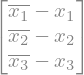

In [4]:
x1_bar, x2_bar, x3_bar = sym.symbols('\overline{x_1}, \overline{x_2}, \overline{x_3}')
x_bar = sym.Matrix([[x1_bar], [x2_bar], [x3_bar]])
d_k = x_bar - x
display(Math(r'd_k: '))
d_k

Adesso visualizzo il punto iniziale e mi calcolo il nuovo punto

<IPython.core.display.Math object>

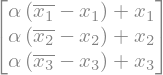

In [5]:
a = sym.symbols('\\alpha')
x_k = x + a * d_k

display(Math(r'x_{k+1}: '))
x_k

Adesso mi calcolo il gradiente

<IPython.core.display.Math object>

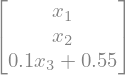

In [6]:
grad = x.T * Q + c.T
display(Math(r'\nabla: '))
grad.T

Adesso mi calcolo ${\alpha}$ come forma chiusa e nella cella successiva sostituisco i valori:

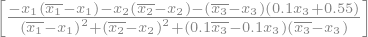

In [7]:
alpha = -(grad * d_k) / (d_k.T * Q * d_k)[0]
alpha

Adesso sostituisco i valori e verifico:

    1. I valori tornano con Gallagher
    2. La direzione scelta con Q
    3. Calcolo del nuovo punto con il quale calcolare la direzione di discesa
\begin{align} \overline{x}_{k+1} = argmin {<\nabla f(x_k), x>} \quad \forall	 x \in C \end{align}

Punto iniziale scelto per far partire l'algoritmo, uso il seguente:

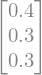

In [8]:
result_x = x.subs({x1: 0.4, x2: 0.3, x3: 0.3})
result_x

Uso questa soluzione iniziale:

In [9]:
result_x_bar = x_bar.subs({x1_bar: 1, x2_bar: 0, x3_bar: 0})
result_x_bar

Mi calcolo la nuova direzione

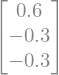

In [10]:
result_d_k = d_k.subs({x1: 0.4, x2: 0.3, x3: 0.3, x1_bar: 1, x2_bar: 0, x3_bar: 0})
result_d_k

Adesso mi calcolo lo step size con la line minimization

In [11]:
step_result = alpha.subs({x1: 0.4, x2: 0.3, x3: 0.3, x1_bar: 1, x2_bar: 0, x3_bar: 0})
step_result

Il nuovo punto è

In [12]:
calc_x = np.array(x.subs({x1: 0.4, x2: 0.3, x3: 0.3}))
calc_a = np.array(a.subs({a: step_result}))
calc_d_k = np.array(d_k.subs({x1: 0.4, x2: 0.3, x3: 0.3, x1_bar: 1, x2_bar: 0, x3_bar: 0}))
new_point = calc_x + calc_a * calc_d_k
new_point

array([[0.431372549019608],
       [0.284313725490196],
       [0.284313725490196]], dtype=object)

#### Seconda iterazione
Adesso inizio con la nuova iterazione. Inizio col punto che mi sono appena calcolato e pongo:

\begin{align} \overline{x}_{1} = argmin {<\nabla f(x_0), x>} \quad \forall	 x \in C \end{align}

Questo me lo calcolo con le condizioni KKT per i problemi con vincoli di simplesso. Dunque il nuovo punto che userò è
soluzione del seguente problema

\begin{align} minimize \sum_{i=1}^{n} \frac{\partial f(x_{k})}{\partial x_{i}}(x_{i}-x_{i}^k) \\ st
\sum_{i=1}^{n} x_{i} = 1
\end{align}

La soluzione a questo problema è un punto $\bar{x}_{k} $ il quale ha tutte le coordinate uguali
a zero eccezione fatta per una sola coordinata la quale è uguale ad 1. La j-esima coordinata corrisponde a quella
coordinata con valore minimo di derivata (vedi le condizioni di KKT per il problema)

\begin{align} j = argmin \frac{\partial f(x_{k})}{\partial x_{i}}\quad \forall i =1 ... n \end{align}

In [13]:
gradient = grad.subs({x1: new_point[0][0], x2: new_point[1][0], x3: new_point[2][0]})
display(Math(r'\nabla f(x_1): '))
gradient

<IPython.core.display.Math object>

Adesso applico le KKT e calcolo il nuovo punto che userò per la direzione di discesa

idx_oracle = np.argmax(np.abs(grad))
mag_oracle = alpha * np.sign(-grad[idx_oracle])

Definisco la per il singolo step dell'iterazione poi la lancio dalla funzione FW (principale)

In [14]:
def step_iteration(x_k: np.ndarray):
    grad = (x_k.T.dot(Q) + c.T).ravel()
    idx_oracle = np.argmin(np.abs(grad))
    mag_oracle = np.sign(grad[idx_oracle])
    d_t = -x_k.copy()
    d_t[idx_oracle] += mag_oracle
    g_t = - d_t.T.dot(grad).ravel()
    step_size = -grad.dot(d_t) / (d_t.T.dot(Q)).dot(d_t)
    step_size = np.minimum(step_size, 1.)
    x_k = x_k + step_size * d_t
    return x_k, g_t, d_t

Questa è la funzione principale in cui metto tutto insieme

In [15]:
Q = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0.1]])
c = np.array([[0], [0], [0.55]])

Esecuzione e test obiettivo, direzione se è di discesa, certificato duale

In [16]:
x_k = np.array([[0.4], [0.3], [0.3]])
s_k = np.array([[1], [0], [0]])
grad = x_k.T.dot(Q) + c.T
point, dual_value, direction = step_iteration(x_k)
display(Math(r'<\nabla f(x_2),d_2> : {:.4f}'.format(direction.T.dot(grad.T).ravel()[0])))
display(Math(r'Dual(x_2): {:.4f}'.format(dual_value.ravel()[0])))
print("Direzione di discesa: ")
print(direction)
print("Punto calcolato")
print(point)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Direzione di discesa: 
[[-0.4]
 [ 0.7]
 [-0.3]]
Punto calcolato
[[0.32473445]
 [0.43171472]
 [0.24355083]]


In [17]:
for i in range(1,321):
    point, dual_value, direction = step_iteration(point)
display(Math(r'<\nabla f(x_3),d_3> : {:.4f}'.format(direction.T.dot(grad.T).ravel()[0])))
display(Math(r'Dual(x_3): {:.4f}'.format(dual_value.ravel()[0])))
print("Direzione di discesa: ")
print(direction)
print("Punto calcolato")
print(point)
obj = 0.5*(point.T.dot(Q)).dot(point) + c.T.dot(point)
display(Math(r'Objective(x_3): {:.4f}'.format(obj.ravel()[0])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Direzione di discesa: 
[[-0.4950977 ]
 [ 0.50615651]
 [-0.01105881]]
Punto calcolato
[[0.49385908]
 [0.49510978]
 [0.01103114]]


<IPython.core.display.Math object>